# Transfer Learning

Neste exemplo, usaremos os pesos da ***ResNet50***, pré-treinados no conjunto ImageNet, para classificação das imagens do CIFAR-10. A expectativa é de que os filtros da rede que foram pré-treinados auxiliem na tarefa de classificação, por mais que as distribuições dos dados sejam diferentes. 
Faremos dois experimentos:

1. Usar a rede como extrator de características, descartando a saída original e congelando suas as camadas. Adicionaremos uma nova camada de saída com o número de classes do CIFAR-10.

2. Após este primeiro treinamento, vamos descongelar as camadas e fazer o _fine-tuning_ das camadas. 

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score

#Utility to plot
def plotImages(imgList, n_row=1, n_col=1):
    _, axs = plt.subplots(n_row, n_col, figsize=(3, 3))
    axs = axs.flatten()
    for img, ax in zip(imgList, axs):
        ax.imshow(np.uint8(img), interpolation='nearest')
    plt.show()
        
        
def plotImage(img):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)

    ax.imshow(np.uint8(img), interpolation='nearest')
    plt.show()

## CIFAR-10

Conjunto de dados composto de 60.000 imagens coloridas de dimensões 32x32, divididas em 10 classes (com 6.000 imagens por classe), sendo 50.000 para treinamento e 10.000 para teste. As classes do CIFAR-10 são **aviões, automóveis, pássaros, gatos, alces, cachorros, sapos, cavalos, navios, caminhões.**

O código abaixo carrega e transforma os dados de entrada para ficarem prontos para serem treinados/classificados pela sua rede. Os conjuntos de treino, validação e teste estão balanceados, portanto a acurácia já estará normalizada nos métodos do Keras. 

***Veja como pré-processamos os dados com a função do próprio modelo pré-treinado.***

In [2]:
#Load data
(trainVal_data, trainVal_label), (X_test, y_test) = cifar10.load_data()

#Split trainVal data into train and val sets (already balanced)
sss = StratifiedShuffleSplit(1, test_size=10000, random_state=0)
for train_index, val_index in sss.split(trainVal_data, trainVal_label):
    X_train, X_val = trainVal_data[train_index], trainVal_data[val_index]
    y_train, y_val = trainVal_label[train_index], trainVal_label[val_index]

#X_train = X_train.astype('float32')
#X_val = X_val.astype('float32')
#X_test = X_test.astype('float32')

print("Dados de treino:", X_train.shape)
print("Dados de validação:", X_val.shape)
print("Dados de teste:", X_test.shape)
print()
n_classes = 10

Y_train = tf.keras.utils.to_categorical(y_train, n_classes)
Y_val = tf.keras.utils.to_categorical(y_val, n_classes)
Y_test = tf.keras.utils.to_categorical(y_test, n_classes)

# Computa a distribuição de amostras por classe
num_train_classes, _ = np.histogram(y_train, bins=np.arange(n_classes)+1)
num_valid_classes, _ = np.histogram(y_val, bins=np.arange(n_classes)+1)
num_test_classes, _ = np.histogram(y_test, bins=np.arange(n_classes)+1)

print("Distribuição de amostras por classe:")
print(" - treino:", num_train_classes)
print(" - validação:", num_valid_classes)
print(" - teste:", num_test_classes)

Dados de treino: (40000, 32, 32, 3)
Dados de validação: (10000, 32, 32, 3)
Dados de teste: (10000, 32, 32, 3)

Distribuição de amostras por classe:
 - treino: [4000 4000 4000 4000 4000 4000 4000 4000 4000]
 - validação: [1000 1000 1000 1000 1000 1000 1000 1000 1000]
 - teste: [1000 1000 1000 1000 1000 1000 1000 1000 1000]


(64, 32, 32, 3) (64, 10)
(64, 32, 32, 3) (64, 10)
imagens apenas com aumentações


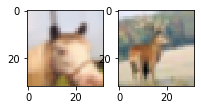

imagens com aumentações + pré-processamento resnet


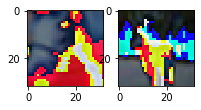

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_for_printing = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen_resnet = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=[0.6, 1],
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
    )

# datagen com preprocessing
gerador_batches_resnet = datagen_resnet.flow(X_train, Y_train, shuffle=False, batch_size=64)
batch_X_proc, batch_Y_proc = gerador_batches_resnet.next()

gerador_batches_printing = datagen_for_printing.flow(X_train, Y_train, shuffle=False, batch_size=64)
batch_X, batch_Y = gerador_batches_printing.next()

print(batch_X_proc.shape, batch_Y_proc.shape)
print(batch_X.shape, batch_Y.shape)
print("imagens apenas com aumentações")
plotImages(batch_X[:2], 1, 2)

print("imagens com aumentações + pré-processamento resnet")
plotImages(batch_X_proc[:2], 1, 2)


## Congelar camadas

Vamos pegar a saída da ResNet50 após todas as convoluções, congelar os pesos, e adicionar uma camada densa treinável para as novas classes do CIFAR-10. Podemos pensar nas camadas congeladas como extrator de características.


In [4]:
# Carregamento do modelo pré-treinado SEM as camadas densas (include_top = False)
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))
model.summary()

# Congela camadas pré-treinadas
for layer in model.layers:
    layer.trainable = False

# Insere novas camadas no fim da rede para classificação
frozen_model = tf.keras.Sequential([
  model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10, activation='softmax')
])

frozen_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Vamos compilar e treinar o modelo

In [5]:
# Instancia um otimizador SGD, compila e treina o modelo completo
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, decay=0.001, nesterov=True)

# Batches de treino e validação
train_batches = datagen_resnet.flow(X_train, Y_train, shuffle=True, batch_size=64)
val_batches = datagen_resnet.flow(X_val, Y_val, shuffle=True, batch_size=64)

# Early Stopping
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

frozen_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

frozen_model.fit(train_batches, epochs=25, callbacks=[early],
                  validation_data=val_batches)

Epoch 1/25
625/625 [==============================] - 53s 77ms/step - loss: 1.8680 - accuracy: 0.4945 - val_loss: 1.5811 - val_accuracy: 0.5283
Epoch 2/25
625/625 [==============================] - 46s 74ms/step - loss: 1.4308 - accuracy: 0.5525 - val_loss: 1.3865 - val_accuracy: 0.5570
Epoch 3/25
625/625 [==============================] - 46s 73ms/step - loss: 1.2913 - accuracy: 0.5749 - val_loss: 1.2953 - val_accuracy: 0.5753
Epoch 4/25
625/625 [==============================] - 46s 73ms/step - loss: 1.2426 - accuracy: 0.5828 - val_loss: 1.2576 - val_accuracy: 0.5766
Epoch 5/25
625/625 [==============================] - 46s 73ms/step - loss: 1.2047 - accuracy: 0.5909 - val_loss: 1.2320 - val_accuracy: 0.5911
Epoch 6/25
625/625 [==============================] - 47s 75ms/step - loss: 1.1704 - accuracy: 0.5982 - val_loss: 1.2046 - val_accuracy: 0.5892
Epoch 7/25
625/625 [==============================] - 46s 74ms/step - loss: 1.1400 - accuracy: 0.6079 - val_loss: 1.2126 - val_accuracy:

In [6]:
# Avalia o modelo na validação
score = frozen_model.evaluate(val_batches,verbose=1)

print('Valid loss:', score[0])
print('Valid acc:', score[1])

157/157 [==============================] - 10s 63ms/step - loss: 1.1167 - accuracy: 0.6095
Valid loss: 1.1167011260986328
Valid acc: 0.609499990940094


## Modelo congelado como extrator de features

Após carregar o modelo pré-treinado, podemos usá-lo como extrator de características, e treinar um SVM sobre a representação obtida.

In [7]:
for layer in model.layers:
    layer.trainable = False

frozen_model = tf.keras.Sequential([
  model,
  tf.keras.layers.GlobalAveragePooling2D()
])

feats_train = frozen_model.predict(X_train)
feats_val = frozen_model.predict(X_val)

In [8]:
print(feats_train.shape)

from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=300).fit(feats_train, Y_train)

(40000, 2048)


In [20]:
acc_mlp = clf.score(feats_val, Y_val)
print("ACC MLP:", acc_mlp)

ACC MLP: 0.4558


## Fine-tuning 

Vamos agora descongelar o modelo inteiro e realizar o _fine-tuning_ da rede para o CIFAR-10.

In [10]:
for layer in model.layers:
    layer.trainable = True

ft_model = tf.keras.Sequential([
  model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10, activation='softmax')
])    
    
ft_model.summary() #Note o núúmero de paramêtros treináveis

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [11]:
# Compila e treina o modelo
sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

# Batches de treino e validação
train_batches = datagen_resnet.flow(X_train, Y_train, shuffle=True, batch_size=64)
val_batches = datagen_resnet.flow(X_val, Y_val, shuffle=True, batch_size=64)

# Early Stopping
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

ft_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
ft_model.fit(train_batches, epochs=25, callbacks=[early],
                  validation_data=val_batches)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/25
625/625 [==============================] - 92s 135ms/step - loss: 1.5328 - accuracy: 0.4869 - val_loss: 1.2031 - val_accuracy: 0.5988
Epoch 2/25
625/625 [==============================] - 84s 134ms/step - loss: 1.0666 - accuracy: 0.6335 - val_loss: 0.9977 - val_accuracy: 0.6551
Epoch 3/25
625/625 [==============================] - 83s 133ms/step - loss: 0.9522 - accuracy: 0.6722 - val_loss: 0.8929 - val_accuracy: 0.6891
Epoch 4/25
625/625 [==============================] - 83s 133ms/step - loss: 0.8696 - accuracy: 0.6989 - val_loss: 0.9037 - val_accuracy: 0.6974
Epoch 5/25
625/625 [==============================] - 83s 132ms/step - loss: 0.8158 - accuracy: 0.7220 - val_loss: 0.8205 - val_accuracy: 0.7148
Epoch 6/25
625/625 [==============================] - 83s 133ms/step - loss: 0.7749 - accuracy: 0.7332 - val_loss: 0.8206 - val_accuracy: 0.7232
Epoch 7/25
625/625 [==============================] - 84s 134ms/step - loss: 0.7922 - accuracy: 0.7272 - val_loss: 0.7626 - val_ac

Finalmente, avalie o modelo final no conjunto de teste

In [12]:
score = ft_model.evaluate(val_batches,verbose=1)
print('Val loss:', score[0])
print('Val acc:', score[1])

157/157 [==============================] - 10s 60ms/step - loss: 0.6469 - accuracy: 0.7813
Val loss: 0.6468590497970581
Val acc: 0.7813000082969666


In [13]:
test_batches = datagen_resnet.flow(X_test, Y_test, shuffle=True, batch_size=64)

score_test = ft_model.evaluate(test_batches,verbose=1)
print('Test loss:', score[0])
print('Test acc:', score[1])

157/157 [==============================] - 10s 62ms/step - loss: 0.6502 - accuracy: 0.7773
Test loss: 0.6468590497970581
Test acc: 0.7813000082969666
